In [2]:
import matplotlib.pyplot as plt
from torchvision import transforms

from flow_models.PatchNrFlowModel import PatchNrFlowModel
from operators import BlurOperator
import torch
from dataset.FastPatchExtractor import FastImageLoader
from kernels import gaussian_kernel_generator
from regularisers import PatchNrRegulariser
import numpy as np
from transforms import image_normalization
from utils import plot_image
from variational_model_solver import variational_model_solver

NameError: name 'FlowModel' is not defined

In [6]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using Device: {DEVICE}')

Using Device: cuda


In [7]:
patch_size = 6

In [22]:
#model_weights = torch.load('patchNR/patchNR_weights/weights_material.pth', map_location=DEVICE)
#model = create_NF(num_layers=5, sub_net_size=512, dimension=patch_size**2)
#model.load_state_dict(model_weights['net_state_dict'])

patchNrFlowModel = PatchNrFlowModel('patchNR/patchNR_weights/weights_material.pth', device=DEVICE)
patchNrFlowModel().parameters()

TypeError: 'PatchNrFlowModel' object is not callable

In [9]:
patch_nr_regulariser = PatchNrRegulariser(patchNrFlowModel, p_size=patch_size, sample_number=50000, padding=True, padding_size=8, device=DEVICE)

In [10]:
kernel_size = 9
std = 5

In [11]:
gaussian_kernel = gaussian_kernel_generator(kernel_size, std).to(DEVICE)
blur_operator = BlurOperator(gaussian_kernel, device=DEVICE)

In [12]:
normalization = transforms.Compose([image_normalization()])
image_loader = FastImageLoader('data/material_pt_nr/test.png', device=DEVICE, transform=normalization)
ground_truth = image_loader[0].to(DEVICE)

In [13]:
degraded_image = blur_operator(ground_truth)
c, w, h = degraded_image.shape

In [14]:
sigma = 0.1
mu = 0
noise_level = 5.
error_dim = w*h
noise_vector_std1 = torch.reshape(torch.tensor(np.random.normal(mu, sigma, error_dim), device=DEVICE), (1, w, h))
noise_degraded_image = degraded_image + normalization(noise_vector_std1*noise_level)

In [15]:
lam = 0.87

In [16]:
reconstructed = variational_model_solver(noise_degraded_image.to(DEVICE), noise_degraded_image.clone().to(DEVICE), blur_operator, regulariser=patch_nr_regulariser, lam=lam)
img, loss_components = reconstructed

/home/jupyter/nf-for-inv-problems/variational_model_solver.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reconstructed_image = torch.tensor(start_tensor.clone(), dtype=torch.float, device=device, requires_grad=True)
  0%|          | 0/600 [00:00<?, ?it/s]


RuntimeError: indices should be either on cpu or on the same device as the indexed tensor (cpu)

In [ ]:
rec_img = img.detach().cpu()

In [ ]:
plot_sel_patch_pos = (325, 325)
plot_patch_size = 50

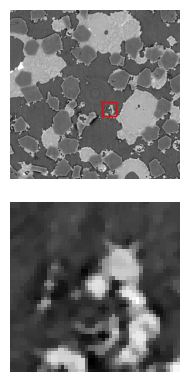

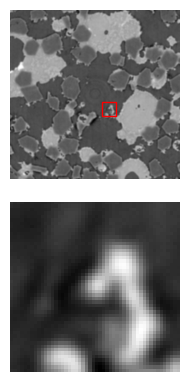

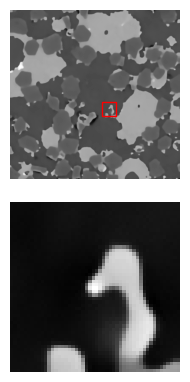

In [39]:
plot_image('results/deblurring/material/ground_truth.png', ground_truth, selected_patch=plot_sel_patch_pos, p_size=plot_patch_size)
plot_image(f'results/deblurring/material/orig_degraded_input_noise_{noise_level}_k_{kernel_size}_std_{std}.png', noise_degraded_image, selected_patch=plot_sel_patch_pos, p_size=plot_patch_size)
plot_image(f'results/deblurring/material/orig_reconstructed_noise_{noise_level}_k_{kernel_size}_std_{std}_lam_{lam}.png', rec_img, selected_patch=plot_sel_patch_pos, p_size=plot_patch_size)

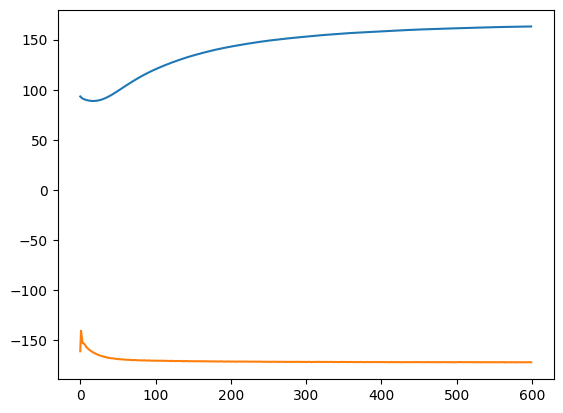

In [40]:
loss, likelihood, regularisation = loss_components
loss = torch.tensor(loss, device='cpu')
likelihood = torch.tensor(likelihood, device='cpu')
regularisation = torch.tensor(regularisation, device='cpu')

plt.plot([i for i in zip(
    #loss,
    likelihood,
    regularisation
)])